# SUMMARY
I have been retained in May 2018 by a Private Equity firm looking to expand their real estate holdings into the New York City area. In particular, they are targeting Hudson County, NJ across the Hudson River to the city’s west. They want to know, quite simply, which areas should they invest in? Which areas will have the highest ROI in a 5 year investment horizon? 

The firm hired me to answer those questions. I used a Zillow dataset that contains almost every county in the United States to answer that question. The dataset contains thousands of zip codes from across the country with the mean home sale price for each month from April 1996 to April 2018. I narrowed the zip codes down to the 13 zip codes in Hudson County. The data is clearly non-stationary and transformations have no effect. Splitting the data into an 80-20 train-test split, I define predicted ROI percentage as the last predicted price-the last observed price/ the final observed price. That number is then multiplied by 100 to generate a percentage:

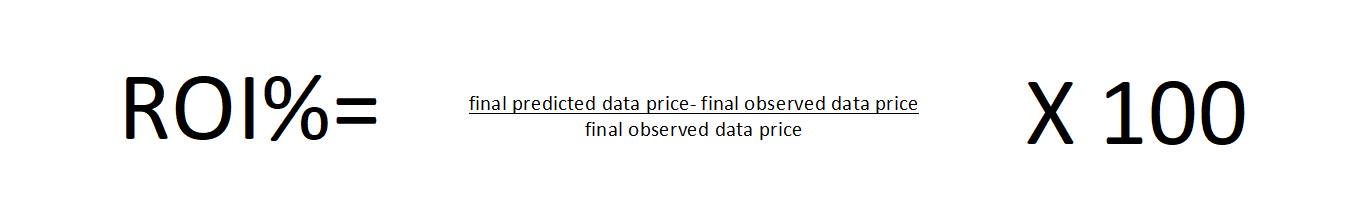

In the interest of time, I first employed pmdarima's auto.arima model to calculate the returns. However, the RMSEs were quite high so I turned to another model. Using a SARIMAX model, I obtained results with lower RMSEs.The top 5 zip codes were **07029, 07030, 07302, 07032, 07307**.


# BUSINESS UNDERSTANDING
The New York City area real estate market is perhaps the most valuable in the country and is among the most valuable in the world.  According to Statista(https://www.statista.com/statistics/815095/new-york-metro-area-population/) , the combined population of the New York metropolitan area is almost 20 million people. When people think of the New York area, they often only think of the city proper consisting of the 5 boroughs of the Bronx, Manhattan, Queens, Brooklyn, and Staten Island. The city's fabled real estate market is lucrative but it’s important for investors to look beyond the city. The city’s suburbs form an essential part of the area’s economic ecosystem. The 4 closest counties to the city’s 4 most populated boroughs are Westchester County, NY to the north, Nassau County, NY to the east, and Hudson County, NJ and Bergen County, NJ to the west over the Hudson River. The city’s doctors, police officers, custodians, bus drivers, teachers, and bankers often reside in these counties. 

A Private Equity firm has hired me to find the zip codes with the highest ROI in the next 5 years. **This analysis will examine average home sale prices fromm every month from  April 1996 to April 2018 to forecast which zip codes have the highest ROI the next 5 years. The projections are for 5 years because that is a typical investment horizon for a PE firm**.  


# DATA UNDERSTANDING
Zillow kindly provided average home sale data for each month from  April 1996 to August 2018 for almost every zip code in the United States. Obviously, that is an immense amount of data. There are some counties with missing information so it’s  best to do a narrow search when using this dataset and to understand its limitations. The dataset consists purely of the months and the prices. 

The evaluation metric I will use is **Root Mean Squared Error(RMSE)**. RMSE is best for this case because it will penalize large error terms and outliers.

# DATA PREPARATION
First, I will import relevant libraries and read the CSV file:


In [31]:
# Importing relevant libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from pmdarima import auto_arima as pm

from pmdarima import model_selection
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline

# Reading zillow csv
df = pd.read_csv('zillow_data.csv')


Showing the DataFrame:

In [32]:
df
df['ROI%']= ((df['2018-04'])-(df['1996-04'])) /df['1996-04']*100
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,208.378217
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,36.529487
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,56.796578
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,162.397109
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,57.179819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,217700,218600,218500,218100,216400,213100,209800,209200,209300,121.247357
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,208400,212200,215200,214300,213100,213700,218300,222700,225800,143.581446
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,122800,124600,126700,128800,130600,131700,132500,133000,133400,133.625219
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,671200,682400,695600,695500,694700,706400,705300,681500,664400,247.671376


Ok, looking for the inner NYC suburban counties: Hudson, Bergen, Nassau, and Westchester.

In [33]:
#Making DataFrames for the 4 relevant counties
Westchester=df[df.CountyName == "Westchester"]
Bergen=df[df.CountyName == "Bergen"]
Nassau=df[df.CountyName == "Nassau"]
Hudson=df[df.CountyName == "Hudson"]

Remember, I'm only looking for NY area counties so let's check and make sure sure that every zip code is in the NYC area.

In [34]:
#A check to see if there is a duplicate county name in another state.
def area_check(county):
    print(county.value_counts())

In [35]:
area_check(Nassau['State'])

NY    63
FL     4
Name: State, dtype: int64


In [36]:
area_check(Bergen['State'])

NJ    65
Name: State, dtype: int64


In [37]:
area_check(Westchester['State'])

NY    61
Name: State, dtype: int64


In [38]:
area_check(Hudson['State'])

NJ    13
Name: State, dtype: int64


So, only the name 'Nassau' has zip codes outside of the NYC area.

In [39]:
#Nassau DataFrame
Hudson

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
57,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,302700.0,303800.0,...,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300,514.820955
187,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0,144500.0,143900.0,...,324100,330900,339000,347400,352800,355900,361500,368700,372900,157.172414
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,940.306122
214,60599,7093,West New York,NJ,New York,Hudson,215,131700.0,131900.0,132100.0,...,368200,376800,386200,392900,395100,395500,399400,407000,412700,213.363705
319,60594,7087,Union City,NJ,New York,Hudson,320,127300.0,127000.0,126700.0,...,377500,386000,394700,403700,410500,415500,424000,437400,448900,252.631579
519,60642,7305,Jersey City,NJ,New York,Hudson,520,105200.0,104500.0,103800.0,...,231200,234600,241100,251100,261600,268600,276000,286700,295100,180.513308
546,60560,7047,North Bergen,NJ,New York,Hudson,547,147200.0,146800.0,146400.0,...,366200,368300,374100,383300,389900,391200,396500,409200,419100,184.714674
660,60643,7306,Jersey City,NJ,New York,Hudson,661,111400.0,111100.0,110900.0,...,469800,475900,484000,495800,506700,510000,515300,531900,545500,389.676840
1737,60644,7307,Jersey City,NJ,New York,Hudson,1738,114300.0,114300.0,114400.0,...,449000,458300,468100,478200,487300,496000,510600,531900,546600,378.215223
2989,60547,7032,Kearny,NJ,New York,Hudson,2990,150300.0,150200.0,150100.0,...,311900,316300,321800,327100,331300,334900,338100,341300,343200,128.343313


Obviously, Jacksonville is not in the NYC area so it must be eliminated. First, zip codes in Florida must be indentified:

In [40]:
# Identifiying the Nassau County, FL zip codes.
Nassau[Nassau.State == "FL"]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
1489,71743,32034,Fernandina Beach,FL,Jacksonville,Nassau,1490,97100.0,96700.0,96400.0,...,330400,333600,336400,339100,341500,343200,344400,346200,348100,258.496395
5642,71785,32097,Yulee,FL,Jacksonville,Nassau,5643,74500.0,74100.0,73700.0,...,195700,195900,196400,197100,198600,199700,200700,203100,205800,176.241611
6786,71736,32011,Callahan,FL,Jacksonville,Nassau,6787,76700.0,76600.0,76400.0,...,188900,189000,189300,190200,191600,192100,192000,194000,196900,156.714472
12592,71735,32009,Bryceville,FL,Jacksonville,Nassau,12593,74000.0,74600.0,75100.0,...,200000,200600,200700,200500,200300,200100,200200,201200,202700,173.918919


Now, I will replace the 'FL' state name with a null value and then eliminate all nulls from the DataFrame:

In [41]:
# Replace 'FL' with nulls.
Nassau = Nassau.replace('FL', np.nan)
#Eliminate nulls and therefore all 'FL' entries.
Nassau.dropna(inplace=True)


Let's check to confirm that the Florida zip codes are gone:

In [42]:
#Checking to confirm the Florida values are gone.
area_check(Nassau['State'])

NY    63
Name: State, dtype: int64


Checking for any null values:

In [43]:
Nassau[Nassau.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%


In [44]:
Bergen[Bergen.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%


In [45]:
Hudson[Hudson.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%


In [46]:
Westchester[Westchester.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,289500,292200,295200,297600,299600,301600,304300,305000,304800,NaN


Ok, so there is a single row with null values in Westchester County. I am going to drop it.

In [47]:
#Dropping the row with null values.
Westchester.dropna(inplace=True)


In [48]:
Westchester[Westchester.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%


In [49]:
Westchester

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,441900,444300,446300,448500,451400,454000,456500,458400,459800,153.054485
2141,61876,10583,Scarsdale,NY,New York,Westchester,2142,407700.0,409400.0,411300.0,...,1061100,1070100,1072900,1069300,1058200,1049700,1053400,1061900,1065400,161.319598
2354,61905,10801,New Rochelle,NY,New York,Westchester,2355,214700.0,214800.0,214900.0,...,536300,538700,537400,536400,537200,539100,537700,533000,530900,147.275268
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,461100,465400,467800,470400,474400,476500,475400,475600,477400,159.738847
2896,61870,10573,Port Chester,NY,New York,Westchester,2897,260900.0,261400.0,261700.0,...,588600,588400,585600,583900,586200,592000,596100,601400,606700,132.541204
3164,61898,10704,Yonkers,NY,New York,Westchester,3165,174000.0,174000.0,173800.0,...,430500,435600,439500,440800,442300,444800,446700,449200,452600,160.114943
3472,61864,10562,Ossining,NY,New York,Westchester,3473,201200.0,201600.0,202000.0,...,419600,420200,419700,417200,413800,412000,412100,414400,416900,107.206759
4125,61904,10710,Yonkers,NY,New York,Westchester,4126,216100.0,216500.0,216800.0,...,486100,489100,492800,495700,496600,497400,498900,500900,502800,132.670060
4136,61886,10598,Yorktown,NY,New York,Westchester,4137,204700.0,205300.0,205800.0,...,447800,450600,450400,447500,445100,444500,444600,445400,445800,117.782120
4469,61902,10708,Eastchester,NY,New York,Westchester,4470,299400.0,301700.0,303900.0,...,863600,861300,851500,841500,837400,833200,842000,864500,883400,195.056780


In [50]:
print('Westchester ROI%=', Westchester['ROI%'].mean())
print('Nassau ROI%=', Nassau['ROI%'].mean())
print('Hudson ROI%=', Hudson['ROI%'].mean())
print('Bergen ROI%=', Bergen['ROI%'].mean())


Westchester ROI%= 129.75361486576284
Nassau ROI%= 176.74947401921432
Hudson ROI%= 311.64702875969203
Bergen ROI%= 130.62872526313458


Ok, so the null values are gone. Now, I will concat the DataFrames.

In [51]:
##Concatenating the DataFrames
NYC_burbs=pd.concat([Westchester, Hudson, Bergen, Nassau], axis=0)
NYC_burbs

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,441900,444300,446300,448500,451400,454000,456500,458400,459800,153.054485
2141,61876,10583,Scarsdale,NY,New York,Westchester,2142,407700.0,409400.0,411300.0,...,1061100,1070100,1072900,1069300,1058200,1049700,1053400,1061900,1065400,161.319598
2354,61905,10801,New Rochelle,NY,New York,Westchester,2355,214700.0,214800.0,214900.0,...,536300,538700,537400,536400,537200,539100,537700,533000,530900,147.275268
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,461100,465400,467800,470400,474400,476500,475400,475600,477400,159.738847
2896,61870,10573,Port Chester,NY,New York,Westchester,2897,260900.0,261400.0,261700.0,...,588600,588400,585600,583900,586200,592000,596100,601400,606700,132.541204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,62130,11514,Carle Place,NY,New York,Nassau,11402,186800.0,186500.0,186100.0,...,525400,528400,529600,526900,523100,520600,521400,527200,533600,185.653105
12008,62212,11732,East Norwich,NY,New York,Nassau,12009,279100.0,278900.0,278700.0,...,624300,625500,626100,626800,629300,634200,639600,649600,660500,136.653529
12628,62128,11509,Atlantic Beach,NY,New York,Nassau,12629,322600.0,323300.0,323900.0,...,809300,814300,818300,823900,831400,834700,842500,861400,880000,172.783633
12835,62158,11568,Old Westbury,NY,New York,Nassau,12836,841900.0,847400.0,852700.0,...,2233100,2233000,2238700,2243800,2255100,2275600,2283800,2277300,2268400,169.438176


Confirming that there are no null values:

In [52]:
NYC_burbs[NYC_burbs.isnull().any(axis=1)] 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%


Calculating the returns during the observed period(April 1996-April 2018):


* Maybe using ROI% over different periods. 
* Maybe focus on other areas as a hedge.
* Maybe focusing on price ranges. 
* Think about the business understanding.
* Better visualizations. --line charts, bar charts, check matplotlib for more. also folium--yelp--phase 1

In [53]:
#Creating an ROI% category.
NYC_burbs['ROI%']= ((NYC_burbs['2018-04'])-(NYC_burbs['1996-04'])) /NYC_burbs['1996-04']*100
NYC_burbs

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,441900,444300,446300,448500,451400,454000,456500,458400,459800,153.054485
2141,61876,10583,Scarsdale,NY,New York,Westchester,2142,407700.0,409400.0,411300.0,...,1061100,1070100,1072900,1069300,1058200,1049700,1053400,1061900,1065400,161.319598
2354,61905,10801,New Rochelle,NY,New York,Westchester,2355,214700.0,214800.0,214900.0,...,536300,538700,537400,536400,537200,539100,537700,533000,530900,147.275268
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,461100,465400,467800,470400,474400,476500,475400,475600,477400,159.738847
2896,61870,10573,Port Chester,NY,New York,Westchester,2897,260900.0,261400.0,261700.0,...,588600,588400,585600,583900,586200,592000,596100,601400,606700,132.541204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11401,62130,11514,Carle Place,NY,New York,Nassau,11402,186800.0,186500.0,186100.0,...,525400,528400,529600,526900,523100,520600,521400,527200,533600,185.653105
12008,62212,11732,East Norwich,NY,New York,Nassau,12009,279100.0,278900.0,278700.0,...,624300,625500,626100,626800,629300,634200,639600,649600,660500,136.653529
12628,62128,11509,Atlantic Beach,NY,New York,Nassau,12629,322600.0,323300.0,323900.0,...,809300,814300,818300,823900,831400,834700,842500,861400,880000,172.783633
12835,62158,11568,Old Westbury,NY,New York,Nassau,12836,841900.0,847400.0,852700.0,...,2233100,2233000,2238700,2243800,2255100,2275600,2283800,2277300,2268400,169.438176


Now let's check out the zip codes with the highest return:

In [54]:
#Sorting by ROI%.
NYC_burbs.sort_values(["ROI%"], ascending=False, inplace=True)
NYC_burbs

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,940.306122
57,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,302700.0,303800.0,...,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300,514.820955
6330,60593,7086,Weehawken,NJ,New York,Hudson,6331,169700.0,169900.0,170000.0,...,676200,695300,715100,730100,742600,749800,767700,804100,836100,392.692988
660,60643,7306,Jersey City,NJ,New York,Hudson,661,111400.0,111100.0,110900.0,...,469800,475900,484000,495800,506700,510000,515300,531900,545500,389.676840
1737,60644,7307,Jersey City,NJ,New York,Hudson,1738,114300.0,114300.0,114400.0,...,449000,458300,468100,478200,487300,496000,510600,531900,546600,378.215223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11463,61863,10560,North Salem,NY,New York,Westchester,11464,286400.0,284200.0,282100.0,...,510200,514300,515200,512500,506100,505100,508100,509900,510100,78.107542
10965,61871,10576,Pound Ridge,NY,New York,Westchester,10966,457500.0,456900.0,456200.0,...,790300,786000,788200,790400,789600,788300,791000,798600,805300,76.021858
14530,61831,10518,Lewisboro,NY,New York,Westchester,14531,341700.0,339700.0,337600.0,...,603600,610100,617600,607200,587000,570100,554400,546700,556700,62.920691
10030,61880,10590,Lewisboro,NY,New York,Westchester,10031,327700.0,326000.0,324200.0,...,541100,537500,531000,521100,512900,510400,509900,509200,510200,55.691181


In [55]:
NYC_burbs['ROI%'].mean()

156.5309068215722

Here are the top 5 returners:

In [56]:
#Top 5 returners
NYC_burbs.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI%
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300,940.306122
57,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,302700.0,303800.0,...,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300,514.820955
6330,60593,7086,Weehawken,NJ,New York,Hudson,6331,169700.0,169900.0,170000.0,...,676200,695300,715100,730100,742600,749800,767700,804100,836100,392.692988
660,60643,7306,Jersey City,NJ,New York,Hudson,661,111400.0,111100.0,110900.0,...,469800,475900,484000,495800,506700,510000,515300,531900,545500,389.676840
1737,60644,7307,Jersey City,NJ,New York,Hudson,1738,114300.0,114300.0,114400.0,...,449000,458300,468100,478200,487300,496000,510600,531900,546600,378.215223


In [131]:
#Hudson['2018-04']
low=Hudson.groupby('2018-04')['State']
low

The 5 highest ROI% zip codes for the dataset are all in Hudson County, NJ and are either in or near Jersey City, NJ. 

# Modeling

First, I will emply a function that will transform the dataset into a longform DataFrame where each zip code represents a column and each date represents a month:

In [57]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

Before I melt the data, I need to eliminate any columns with string values so I have to eliminate the ROI% column:

In [58]:
Hudson.drop('ROI%', axis=1, inplace=True)

Metling the data on the NYC suburbs:

In [59]:
Suburbs = pd.DataFrame()
for i in Hudson['RegionName']:
    x = melt_data(Hudson[NYC_burbs['RegionName'] == i])  
    Suburbs = pd.concat([Suburbs, x], axis=1)
    Suburbs.rename(columns = {'value':i}, inplace = True)
Suburbs

,7030,7002,7302,7093,7087,7305,7047,7306,7307,7032,7094,7086,7029
time,,,,,,,,,,,,,
1996-04-01,301600.0,145000.0,137200.0,131700.0,127300.0,105200.0,147200.0,111400.0,114300.0,150300.0,189600.0,169700.0,154200.0
1996-05-01,302700.0,144500.0,137800.0,131900.0,127000.0,104500.0,146800.0,111100.0,114300.0,150200.0,189300.0,169900.0,154300.0
1996-06-01,303800.0,143900.0,138500.0,132100.0,126700.0,103800.0,146400.0,110900.0,114400.0,150100.0,188900.0,170000.0,154400.0
1996-07-01,304800.0,143300.0,139100.0,132300.0,126400.0,103100.0,146000.0,110600.0,114500.0,150200.0,188500.0,170100.0,154400.0
1996-08-01,305800.0,142800.0,139600.0,132500.0,126100.0,102600.0,145800.0,110300.0,114800.0,150200.0,188100.0,170200.0,154500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1853500.0,352800.0,1447800.0,395100.0,410500.0,261600.0,389900.0,506700.0,487300.0,331300.0,486600.0,742600.0,373000.0
2018-01-01,1852200.0,355900.0,1454900.0,395500.0,415500.0,268600.0,391200.0,510000.0,496000.0,334900.0,487300.0,749800.0,370300.0
2018-02-01,1854400.0,361500.0,1453900.0,399400.0,424000.0,276000.0,396500.0,515300.0,510600.0,338100.0,492100.0,767700.0,370300.0


In [60]:
# Null Check
Suburbs[Suburbs.isnull().any(axis=1)] 

,7030,7002,7302,7093,7087,7305,7047,7306,7307,7032,7094,7086,7029
time,,,,,,,,,,,,,


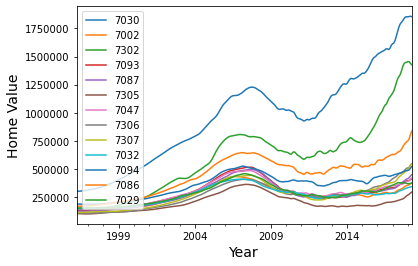

In [95]:
Suburbs.plot()
plt.xlabel('Year',fontsize=14)
plt.ylabel('Home Value',fontsize=14)
plt.ticklabel_format(axis='y',style='plain',useOffset=False);

## Train-Test Split

In [ ]:
f'{265*.8} months will be in training set'

In [ ]:
f'{265*.2} months will be in test set'

In [ ]:


# Train test split with the first 212 out 265 months as training data.
train_1 = Suburbs.iloc[:212, :]
# The last 60 months, 5 years, will be used as test data.
test_1 = Suburbs.iloc[212:, :]

Here's the train data:

In [ ]:
# Train DataFrame
train_1

Here's the test data:

In [ ]:
# Test Data
test_1

Here is a function that test for stationarity:

In [ ]:
#Function to check for stationarity for each zipcode. 
def dftest_stationarity(data):
    for x in data:
        # Check to see if the p-value ≤ .05. If so, it returns the the stationary zipcodes with associated values.
        if  adfuller(data[x])[1] <=.05: 
            return(x, adfuller(data[x])[0:6])
        

Let's check for stationarity in the Suburbs dataset:

In [ ]:
dftest_stationarity(Suburbs)

Only 07093 is stationary.

Now, for the training set:

In [ ]:
dftest_stationarity(train_1)

None are stationary. Let's try differencing the values to see if that makaes any difference:

In [ ]:
#Differenced data of 1 month
train_1.diff()[1:]

In [ ]:
dftest_stationarity(train_1.diff()[1:])

Only 1 zipcode, 10706 is stationary. Maybe taking the square root of the training values will help?

In [ ]:
#Creating square root of training data
train_sqrt = np.sqrt(train_1)
train_sqrt

Now, let's see if using the square root values makes the data more stationary:

In [ ]:
dftest_stationarity(train_sqrt)

Perhaps a logarithmic transformation will make the data more stationary.


In [ ]:
# Log transformed data
train_log = np.log(train_1)
train_log.head(3)

In [ ]:
dftest_stationarity(train_log)

No, the log transfomation did not significantly make the data more stationary.

**So, far none of these methods have yielded a significant amount of stationary data. Therefore, it's best to use pmdarima's autoarima**.

However, before I use auto_arima, I want to add rows to my DataFrame so I can graph the predictions. First, I have to make a copy of 'Suburbs', then I will add the rows, then I will make it into a DataFrame. Lastly, I must take the DataFrame's index and convert it into an array.

In [ ]:
#For Loop to get 60 more rows that will be used for subsequent 5 years
burbs_copy=Suburbs.copy(deep=True)
for i in range(1,61):
    idx = burbs_copy.tail(1).index[0] + pd.Timedelta(days=(365/12))
    burbs_copy.loc[idx] = 0
#Making the list into a DataFrame, making the index into an array

burbs_2=pd.DataFrame(burbs_copy)
#Make the index into an array
date_list=burbs_2.index.to_numpy()
dates=pd.to_datetime(date_list, format='%Y-%d-%m')
dates[265:]

Next, I will import a few time functions because it's practical to know how long the it will take to do auto_arima on 201 zipcodes:

In [31]:
#importing time functions
import timeit
import time


In [ ]:
%%time

#This is an empty dictionary that will later hold our ROI% values.
ROI_dict={}
for area in Suburbs:
    #80/20 split for each zipcode
    train, test = model_selection.train_test_split(Suburbs[area], train_size=.8)

    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model_0 = pm(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                         max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                         stepwise=True, suppress_warnings=True, D=5, max_D=5,
                         error_action='ignore')
    #printing model summary
    print(model_0.summary())
    #Creating the predictions. 
    #conf_int returns confidence level at 95% level.
    preds, conf_int = model_0.predict(n_periods=test.shape[0]+60, return_conf_int=True)
   


    
    #Print the errors:
    print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds[:53])))
    
    #Printing how far the values have changed from the end of the 2
    print("From $ : %.3f" % test[52], " on 11/1/2013 to $ %.3f" % preds[112], " on 4/1/2018 for", area)
    #
    ROI_percent=((preds[112]-test[52])/(test[52])*100)
    print(("ROI_percent: %.3f"%  ROI_percent))
    #ROI_percent_real=((test[52]-train[211])/(train[211])*100)
    #print(("Actual Test Data ROI_percent: %.3f"%  ROI_percent_real))

    #Graphing, 'dates' is used as the x values while the train, test, and prediction values are the y values
    # Lines 45-55 will graph the training, test, predicted values and the confidence intervals for every zipcode. 
    # Section is under comments so notebook can load more easily. Uncomment if you want to see graphs.
    plt.figure(figsize=(12,6))
    plt.plot(dates[:212], train)
    plt.plot(dates[212:265], test)
    plt.plot(dates[212:], preds)
    plt.fill_between(dates[212:], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{area} Prices and Next 5 year projections ')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    ROI_dict[area] = ROI_percent

stop = timeit.default_timer()
    
    
    
    


# Results

Here's the dictionary of  ROI%

In [ ]:
#Dictionary containing 5 year returns
ROI_dict

Here are the top 5:

In [ ]:
#Getting the top 5 ROI% as a DataFrame
from operator import itemgetter, attrgetter
Zip_by_ROI= sorted(ROI_dict.items(), key=itemgetter(1), reverse=True)[:5]
top_5_Zip_ROI= pd.DataFrame(Zip_by_ROI)
top_5_Zip_ROI.rename( columns={0 :'Zipcode', 1:'Projected 5 Year ROI%'}, inplace=True )
top_5_Zip_ROI

In [ ]:
#Graphing the top 5 zip codes. "Zip code" column must be converted to string.
top_5_Zip_ROI = top_5_Zip_ROI.assign(Zipcode= (top_5_Zip_ROI['Zipcode'].apply(lambda x: str(x))))
fig, ax1 = plt.subplots(ncols=1, figsize=(12,6))
ax1.bar(
    x=top_5_Zip_ROI['Zipcode'],
    height=top_5_Zip_ROI['Projected 5 Year ROI%'], color='green'
)
ax1.set_title("Top 5 Zip codes by Projected 5 Year ROI%")

ax1.set_xlabel("Zip code")
ax1.set_ylabel("Projected 5 Year ROI%");

Now, I want to examine each zip code individually so I need a function that will predict future values and graph them along with the test and train data. The new wrinkle here is the addition of the baseline model which consists of shifting the data 1 year into the future.

In [ ]:
ROI_dict_2=dict();

def model_comparison(Suburban_zip):


    # Moving the data 12 months into the future
    baseline_burbs = Suburban_zip.shift(12)
    #80/20 split for each zipcode
    train, test = model_selection.train_test_split(Suburban_zip, train_size=.8)

    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model_1 = pm(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                         max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                         stepwise=True, suppress_warnings=True, D=5, max_D=5,
                         error_action='ignore')
  
    #Creating the predictions. The test data comprises 53 months but I need to add a further 60 to get to 5 years.
    #conf_int returns confidence level at 95% level
    preds, conf_int = model_1.predict(n_periods=test.shape[0]+60, return_conf_int=True)
    

    
    print("Test RMSE for baseline: %.3f" % np.sqrt(mean_squared_error(Suburban_zip[12:], baseline_burbs[12:])))
    print("Test RMSE for model: %.3f" % np.sqrt(mean_squared_error(test, preds[:53])))
    ROI_percent=((preds[112]-test[52])/(test[52])*100)
    print(("Predicted ROI_percent: %.3f"%  ROI_percent))
    ROI_percent_real=((test[52]-train[211])/(train[211])*100)
    print(("Testing period ROI_percent: %.3f"%  ROI_percent_real))

    #Graphing, 'dates' is used as the x values while the train, test, and prediction values are the y values.
    plt.figure(figsize=(12,6))
    plt.plot(dates[:265],baseline_burbs)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Baseline'], loc='upper left') 
    plt.title(f'{Suburban_zip.name}  Baseline Prices')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(dates[:212], train)
    plt.plot(dates[212:265], test)
    plt.plot(dates[212:], preds, color='green')
    plt.fill_between(dates[212:], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{Suburban_zip.name} Prices and Next 5 year projections ')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(dates[:265], Suburban_zip)
    #plt.plot(dates[212:265], test)
    plt.plot(dates[:265],baseline_burbs)
    plt.plot(dates[212:], preds)

    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Actual Sales Data', 'Baseline', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{Suburban_zip.name} Prices and Next 5 year projections with Baseline')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    #ROI_dict_2 = ROI_percent
    ROI_dict_2[Suburban_zip.name] = ROI_percent


    
 
    
    
    
    


In [ ]:

mini_burbs=Suburbs.iloc[:, :2]
for x in mini_burbs:
    model_comparison(mini_burbs[x])
#ROI_dict_2[mini_burbs]
    

In [ ]:
ROI_dict_2


* One-Step Ahead Forecasting 1st. One-step vs dynamic--look up for each model. 
* SARIMAX 1ST.
* Maybe start after GFC.
* MAYBE ENGINEER SO you are looking at changes in prices instead.
* Maybe narrow to around 15 zpicodes. 
* 2 notebooks: 1.) Trying out models, 2.) Final results with reference to 1st notebook.

In [32]:
p = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 2, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 2, 12)
SARIMAX: (0, 1, 0) x (2, 1, 0, 12)
SARIMAX: (0, 1, 0) x (2, 1, 1, 12)
SARIMAX: (0, 1, 0) x (2, 1, 2, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 2, 12)
SARIMAX: (0, 1, 1) x (2, 1, 0, 12)
SARIMAX: (0, 1, 1) x (2, 1, 1, 12)
SARIMAX: (0, 1, 1) x (2, 1, 2, 12)
SARIMAX: (0, 1, 2) x (0, 1, 0, 12)
SARIMAX: (0, 1, 2) x (0, 1, 1, 12)
SARIMAX: (0, 1, 2) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
SARIMAX: (0, 1, 2) x (1, 1, 2, 12)
SARIMAX: (0, 1, 2) x (2, 1, 0, 12)
SARIMAX: (0, 1, 2) x (2, 1, 1, 12)
SARIMAX: (0, 1, 2) x (2, 1, 2, 12)
SARIMAX: (1, 1, 0) 

In [33]:
#Making a dictionary to hold the ROI% for each zip code
ROI_dict_sarimax=dict();

def sarimax_model(Suburbs):

    combos = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod=SARIMAX(Suburbs[:212],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
                results = mod.fit()
                #Remove comment in next line to see AIC for each combination
                #print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
                combos.append([param, param_seasonal, results.aic])
            except: 
                print('Oops!')
                continue
    combos_df = pd.DataFrame(combos, columns=['pdq', 'pdqs', 'aic'])

# Sort combinations and make into dataframe
    top_5_combos=combos_df.sort_values(by=['aic'],ascending=True)[0:5]
    print('PDQ is', top_5_combos.iloc[0,0])
    print('Seasonal PDQ is', top_5_combos.iloc[0,1])

    sari_mod =SARIMAX(Suburbs[:212],
                      order=top_5_combos.iloc[0,0],
                      seasonal_order=top_5_combos.iloc[0,1],
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit()
    preds_df = (sari_mod
                .get_prediction(start='2013-12-01', end='2023-04-01')
                .summary_frame(alpha=0.05)
               )
    print((Suburbs.name), "Test RMSE: %.3f" % np.sqrt(mean_squared_error(Suburbs[212:], preds_df['mean'][:53])))
    print((Suburbs.name),'ROI%=', (preds_df['mean'][112]-Suburbs[211])/Suburbs[211] *100)
    ROI_sarimax=(preds_df['mean'][112]-Suburbs[211])/Suburbs[211] *100
    ROI_dict_sarimax[Suburbs.name] = ROI_sarimax

    # Graphing the dataset, predictions and confidence intervals
    fig, ax = plt.subplots(figsize=(15,5))
    Suburbs.plot()
    preds_df['mean'].plot()
    ax.fill_between(
        preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
        color='purple', alpha=0.5)
    plt.legend(['Actual Sales Data', 'Predictions', 'Confidence Interval'], loc='upper left')
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.title(f'{Suburbs.name} Prices and Next 5 year projections')
    plt.show()
    

mini_burbs=Suburbs.iloc[:, :2]
for x in mini_burbs:
    sarimax_model(mini_burbs[x])
#print(ROI_dict_sarimax)

ROI_dict_sarimax

PDQ is (1, 1, 2)
Seasonal PDQ is (2, 1, 2, 12)
7030 Test RMSE: 140271.395
7030 ROI%= 64.34021087675617


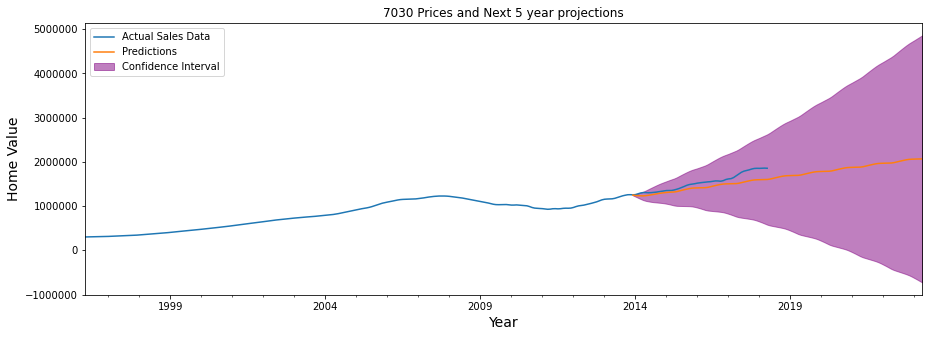

PDQ is (2, 1, 2)
Seasonal PDQ is (1, 1, 2, 12)
7002 Test RMSE: 55167.174
7002 ROI%= -16.8235850189552


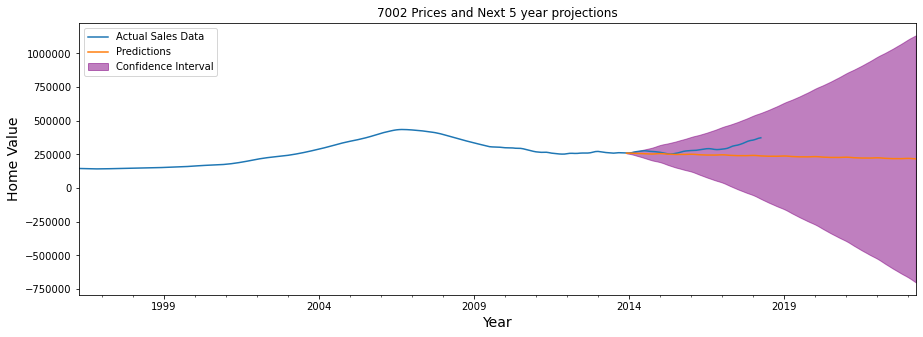

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7302 Test RMSE: 329429.979
7302 ROI%= 35.07894065874501


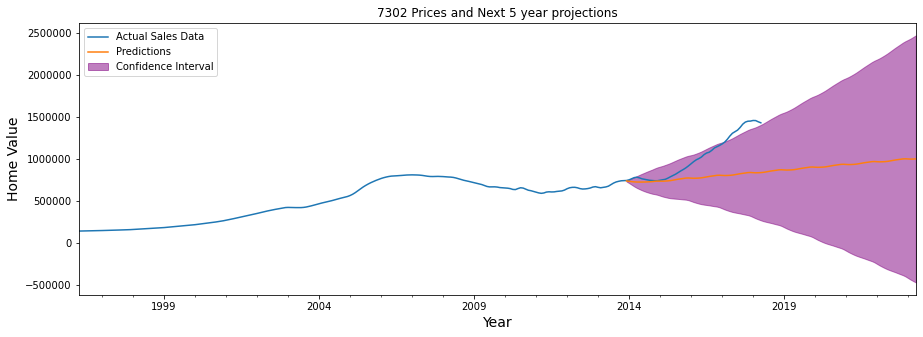

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7093 Test RMSE: 100467.331
7093 ROI%= -32.350785741948464


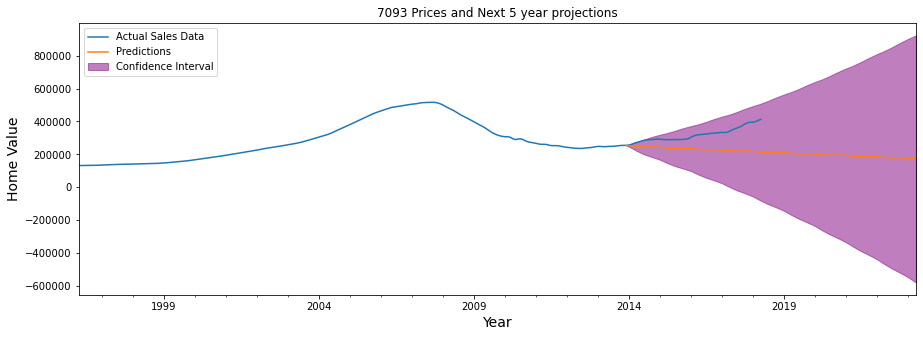

PDQ is (2, 1, 2)
Seasonal PDQ is (1, 1, 2, 12)
7087 Test RMSE: 133367.762
7087 ROI%= -68.05724064865892


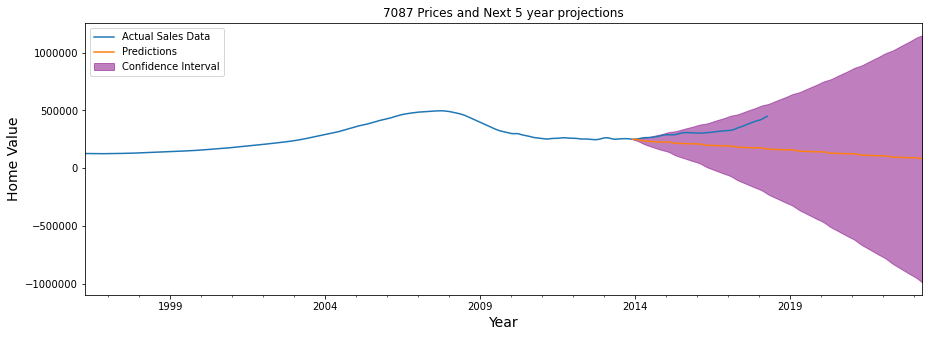

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7305 Test RMSE: 59955.059
7305 ROI%= -34.44044184456906


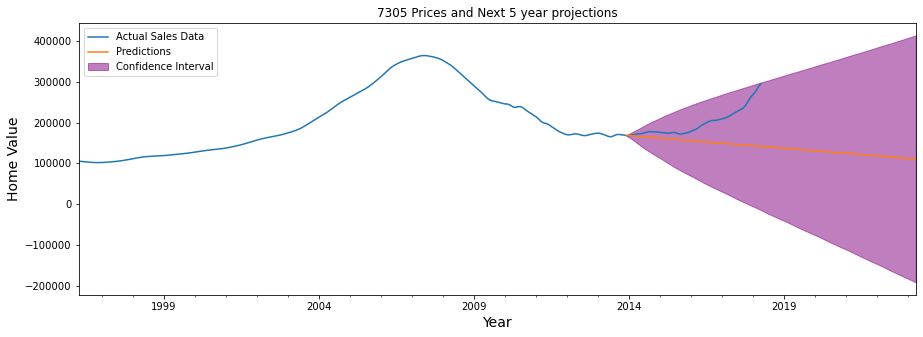

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7047 Test RMSE: 111580.729
7047 ROI%= -59.30221982100405


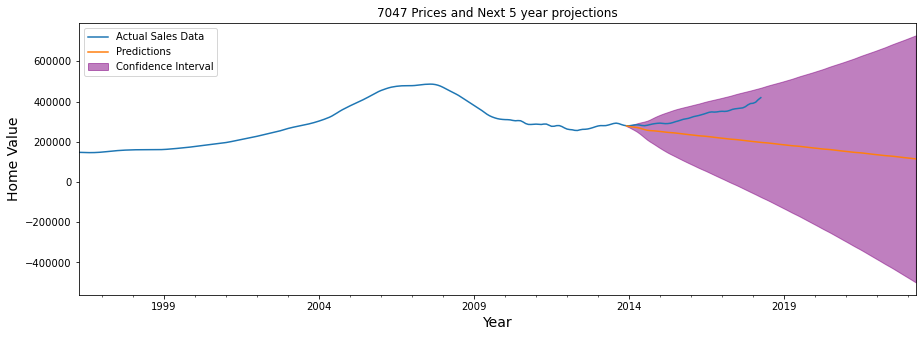

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7306 Test RMSE: 170350.428
7306 ROI%= -44.52820199649732


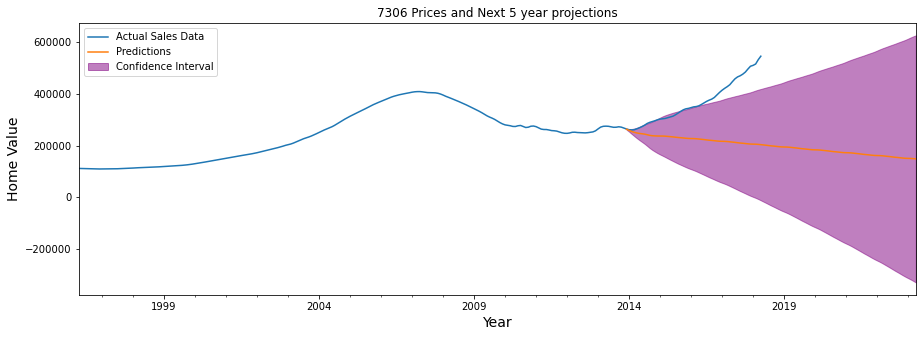

PDQ is (1, 1, 2)
Seasonal PDQ is (1, 1, 2, 12)
7307 Test RMSE: 98342.213
7307 ROI%= 32.50828072813367


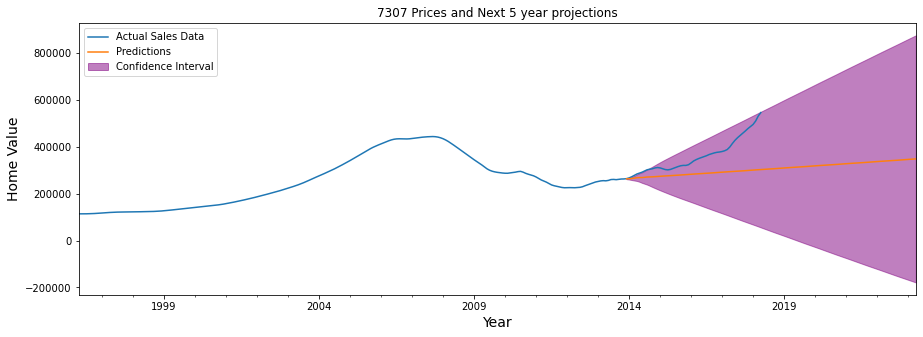

PDQ is (1, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7032 Test RMSE: 14682.671
7032 ROI%= 32.61025143519095


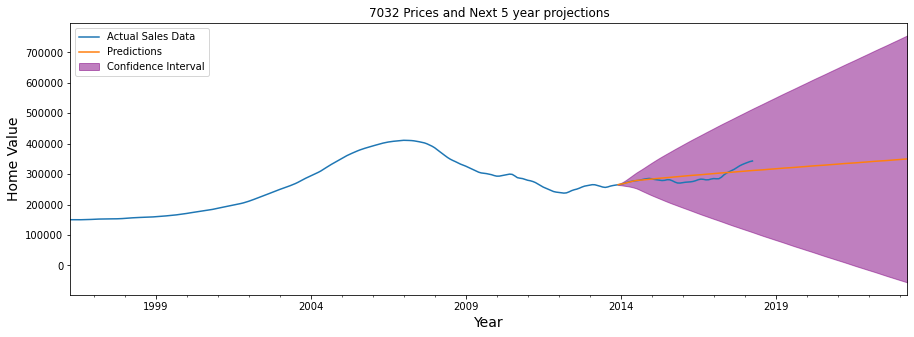

PDQ is (2, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7094 Test RMSE: 27444.519
7094 ROI%= 23.759478915376008


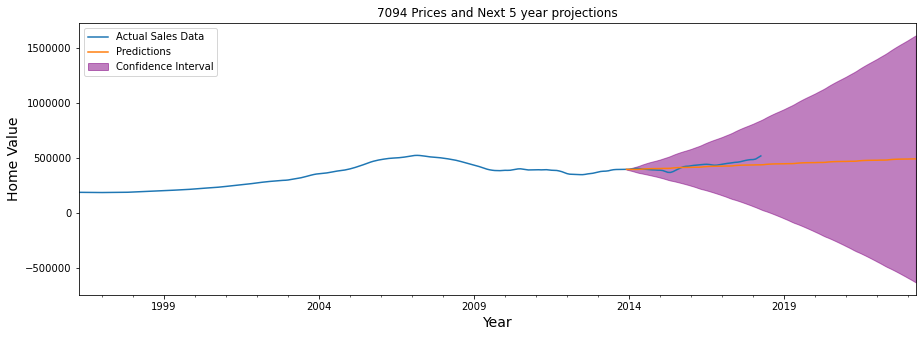

PDQ is (2, 1, 2)
Seasonal PDQ is (2, 1, 2, 12)
7086 Test RMSE: 86213.878
7086 ROI%= 21.83483405635115


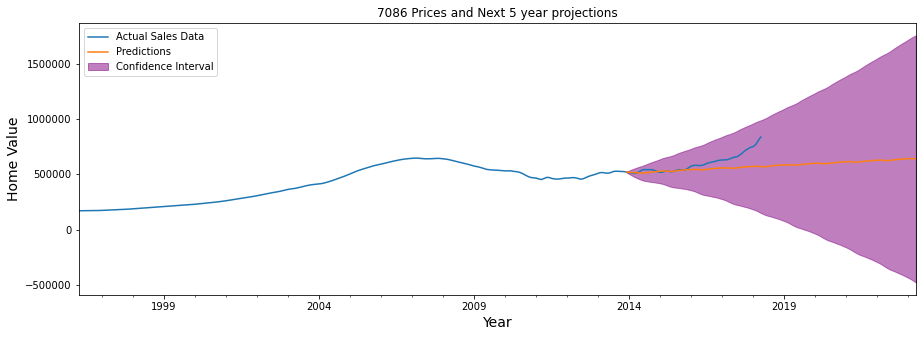

PDQ is (2, 1, 2)
Seasonal PDQ is (0, 1, 2, 12)
7029 Test RMSE: 11651.646
7029 ROI%= 120.99772913796969


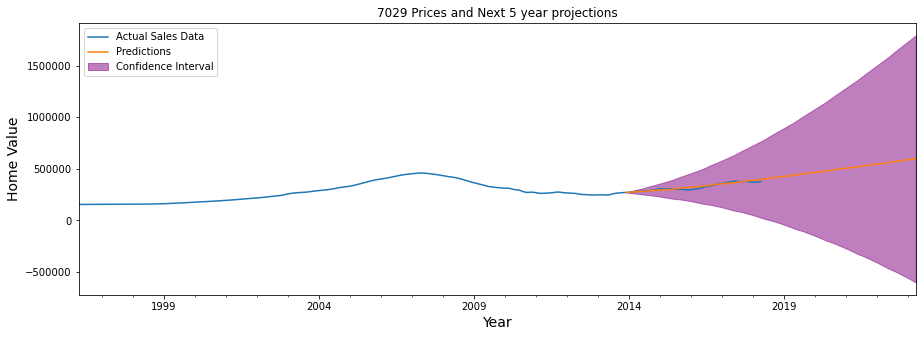

Wall time: 30min 36s


In [34]:
%%time

for x in Suburbs:
    sarimax_model(Suburbs[x])

stop = timeit.default_timer()


In [106]:
ROI_dict_sarimax_2= {7002: -16.8235850189552, 7029: 120.99772913796969, 7030: 64.34021087675617, 7032: 32.61025143519095,
                     7047: -59.30221982100405, 7086: 21.83483405635115, 7087: -68.05724064865892, 7093: -32.350785741948464,
                     7094: 23.759478915376008, 7302: 35.07894065874501, 7305: -34.44044184456906, 7306: -44.52820199649732,
                     7307: 32.50828072813367}
ROI_dict_sarimax_2

{7002: -16.8235850189552,
 7029: 120.99772913796969,
 7030: 64.34021087675617,
 7032: 32.61025143519095,
 7047: -59.30221982100405,
 7086: 21.83483405635115,
 7087: -68.05724064865892,
 7093: -32.350785741948464,
 7094: 23.759478915376008,
 7302: 35.07894065874501,
 7305: -34.44044184456906,
 7306: -44.52820199649732,
 7307: 32.50828072813367}

In [107]:
ROI_dict_sarimax_2

{7002: -16.8235850189552,
 7029: 120.99772913796969,
 7030: 64.34021087675617,
 7032: 32.61025143519095,
 7047: -59.30221982100405,
 7086: 21.83483405635115,
 7087: -68.05724064865892,
 7093: -32.350785741948464,
 7094: 23.759478915376008,
 7302: 35.07894065874501,
 7305: -34.44044184456906,
 7306: -44.52820199649732,
 7307: 32.50828072813367}

In [114]:
from operator import itemgetter, attrgetter
Zip_by_ROI_sarimax= sorted(ROI_dict_sarimax_2.items(), key=itemgetter(1), reverse=True)
top_5_Zip_ROI_sarimax= pd.DataFrame(Zip_by_ROI_sarimax)
top_5_Zip_ROI_sarimax.rename( columns={0 :'Zipcode', 1:'Projected 5 Year ROI%'}, inplace=True )
top_5_Zip_ROI_sarimax

,Zipcode,Projected 5 Year ROI%
0,7029,120.997729
1,7030,64.340211
2,7302,35.078941
3,7032,32.610251
4,7307,32.508281
5,7094,23.759479
6,7086,21.834834
7,7002,-16.823585
8,7093,-32.350786
9,7305,-34.440442


In [115]:
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: str(x))))
top_5_Zip_ROI_sarimax

,Zipcode,Projected 5 Year ROI%
0,7029,120.997729
1,7030,64.340211
2,7302,35.078941
3,7032,32.610251
4,7307,32.508281
5,7094,23.759479
6,7086,21.834834
7,7002,-16.823585
8,7093,-32.350786
9,7305,-34.440442


In [132]:
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7002', '07002'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7029', '07029'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7030', '07030'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7032', '07032'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7047', '07047'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7086', '07086'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7087', '07087'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7093', '07093'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7094', '07094'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7302', '07302'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7305', '07305'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7306', '07306'))))
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: x.replace('7307', '07307'))))


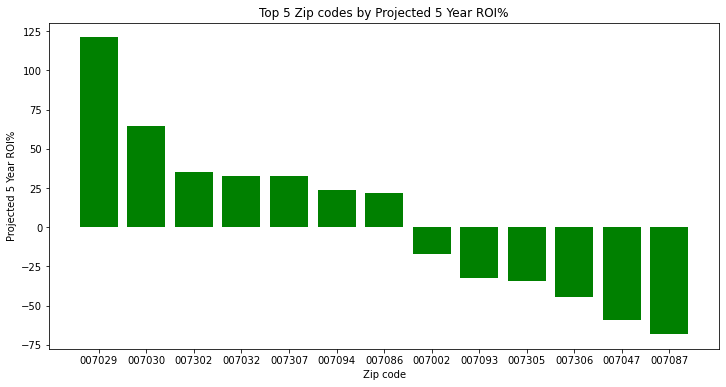

In [133]:
top_5_Zip_ROI_sarimax = top_5_Zip_ROI_sarimax.assign(Zipcode= (top_5_Zip_ROI_sarimax['Zipcode'].apply(lambda x: str(x))))
fig, ax1 = plt.subplots(ncols=1, figsize=(12,6))
ax1.bar(
    x=top_5_Zip_ROI_sarimax['Zipcode'],
    height=top_5_Zip_ROI_sarimax['Projected 5 Year ROI%'], color='green'
)
ax1.set_title("Top 5 Zip codes by Projected 5 Year ROI%")

ax1.set_xlabel("Zip code")
ax1.set_ylabel("Projected 5 Year ROI%");

In [65]:
import json
import geojson
import folium


In [118]:
import json

codes = open("zipcodes.json", encoding='utf8')


with open("zipcodes.json") as f:
    hudson_codes = json.load(f)

In [76]:
projected=top_5_Zip_ROI_sarimax.T
projected.rename( columns={0 :7029, 1:7030, 2:7302, 3: 7032, 4: 7307, 5:7094, 6:7086, 7:7002,
                          8:7093, 9:7305, 10: 7306, 11:7047, 12: 7087}, inplace=True )
projected

,7029,7030,7302,7032,7307,7094,7086,7002,7093,7305,7306,7047,7087
Zipcode,7002,7029,7030,7032,7047,7086,7087,7093,7094,7302,7305,7306,7307
Projected 5 Year ROI%,-16.823585,120.997729,64.340211,32.610251,-59.30222,21.834834,-68.057241,-32.350786,23.759479,35.078941,-34.440442,-44.528202,32.508281


In [74]:
 list(x for x in top_5_Zip_ROI_sarimax['Zipcode'])

['7002',
 '7029',
 '7030',
 '7032',
 '7047',
 '7086',
 '7087',
 '7093',
 '7094',
 '7302',
 '7305',
 '7306',
 '7307']

json_zips = sorted([int(hudson_codes['features'][i]['properties']
['ZCTA5CE10'])for i in range(len(hudson_codes['features']))])
json_zips

job_data_zips = list(projected.columns)
json_zips = sorted([int(hudson_codes['features'][i]['properties']
['ZCTA5CE10'])for i in range(len(hudson_codes['features']))])
set(json_zips) & set(job_data_zips)# Output:


In [ ]:
job_data_zips#002, 29,30,02,32,,94,86,93,47,05,07

In [ ]:
top_5_Zip_ROI_sarimax.to_csv('./top_5_Zip_ROI_sarimax.csv')

In [ ]:
hudson_codes

In [67]:
state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=10)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["State", "Unemployment"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unemployment Rate (%)",
).add_to(m)

folium.LayerControl().add_to(m)

NameError: name 'state_unemployment' is not defined

In [ ]:
for x in top_5_Zip_ROI_sarimax['Zipcode']:
    

In [134]:
#divisions=[0,0.25,0.5,0.75,1]
#quantiles = list(top_5_Zip_ROI_sarimax['Projected 5 Year ROI%'].quantile(divisions))
m = folium.Map(location=[40.7438869,-74.1514239], zoom_start=11)
folium.Choropleth(
    geo_data=hudson_codes,
    data=top_5_Zip_ROI_sarimax,
    columns=['Zipcode', 'Projected 5 Year ROI%'],
    key_on='properties.ZCTA5CE10',
    fill_color='RdYlGn',
    fill_opacity=0.9,
    line_opacity=0.9,
    bins=quantiles,
    #legend_name=f'Number of Jobs by ZIP Code in 2001',
).add_to(m)
m

In [73]:
import pandas as pd

url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
state_unemployment = f"{url}/US_Unemployment_Oct2012.csv"
state_data = pd.read_csv(state_unemployment)

n = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["State", "Unemployment"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unemployment Rate (%)",
).add_to(n)

folium.LayerControl().add_to(n)

n

In [75]:
hudson_codes['features'][2]['properties']

{'STATEFP10': '34',
 'ZCTA5CE10': '07302',
 'GEOID10': '3407302',
 'CLASSFP10': 'B5',
 'MTFCC10': 'G6350',
 'FUNCSTAT10': 'S',
 'ALAND10': 3810135,
 'AWATER10': 168718,
 'INTPTLAT10': '+40.7193887',
 'INTPTLON10': '-074.0464691',
 'PARTFLG10': 'N'}

In [ ]:
for x in zip_codes['features']:
    for n in x['properties']:
        if ['ZCTA5CE10']==['7029', 7030, 7302, 7032, 7307, 7094, 7086, 7002, 7093, 7305, 7306, 7047, 7087]:
            print(n)

In [ ]:
import json
zip_code_file = open("C:\Users\isaia\Flatiron\dsc-data-science-env-config\phase_4\dsc-phase-4-choosing-a-dataset\time-series\nj_zip_codes_geo.json", encoding='utf8')


In [ ]:
import geojson

In [ ]:
function initMap(): void {
  const map = new google.maps.Map(
    document.getElementById("map") as HTMLElement,
    {
      zoom: 3,
      center: { lat: 0, lng: -180 },
      mapTypeId: "terrain",
    }
  );

  const flightPlanCoordinates = [
    { lat: 37.772, lng: -122.214 },
    { lat: 21.291, lng: -157.821 },
    { lat: -18.142, lng: 178.431 },
    { lat: -27.467, lng: 153.027 },
  ];
  const flightPath = new google.maps.Polyline({
    path: flightPlanCoordinates,
    geodesic: true,
    strokeColor: "#FF0000",
    strokeOpacity: 1.0,
    strokeWeight: 2,
  });

  flightPath.setMap(map);
}

declare global {
  interface Window {
    initMap: () => void;
  }
}
window.initMap = initMap;

In [ ]:
import folium


zip_7029 = folium.Map(location=[40.7438869,-74.1514239],zoom_start=15,
               min_zoom = 12,
               max_zoom = 20)
zip_7029

In [ ]:
import folium
import json

with open('datasets/world-countries.json') as handle:
    country_geo = json.loads(handle.read())

for i in country_geo['features']:
    if i['properties']['name'] == 'Germany':
        country = i
        break

m = folium.Map(location = [51.1657,10.4515],
               zoom_start=6,
               min_zoom = 5,
               max_zoom = 7)


folium.GeoJson(country,
               name='germany').add_to(m)

folium.LayerControl().add_to(m)

m

In [ ]:
shorter=Suburbs.iloc[153:]
shorter.plot()

In [ ]:
dftest_stationarity(shorter)

In [ ]:
shorter.iloc[90:]

In [ ]:
preds_df['mean']

In [ ]:
combos = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(shorter[7002][:90],
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
            results = mod.fit()
            #Remove comment in next line to see AIC for each combination
            #print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
            combos.append([param, param_seasonal, results.aic])
        except: 
            print('Oops!')
            continue
combos_df_1 = pd.DataFrame(combos, columns=['pdq', 'pdqs', 'aic'])
# Sort combinations and make into dataframe
top_5_combos_1=combos_df_1.sort_values(by=['aic'],ascending=True)[0:5]
print('PDQ is', top_5_combos_1.iloc[0,0])
print('Seasonal PDQ is', top_5_combos_1.iloc[0,1])

sari_mod =SARIMAX(shorter[7002][:90],
                  order=top_5_combos_1.iloc[0,0],
                  seasonal_order=top_5_combos_1.iloc[0,1],
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
preds_df = (sari_mod
            .get_prediction(start='2016-07-01', end='2023-04-01')
            .summary_frame(alpha=0.05)
           )
print((shorter[7002].name), "Test RMSE: %.3f" % np.sqrt(mean_squared_error(shorter[7002][90:], preds_df['mean'][:22])))
print((shorter[7002].name),'ROI%=', (preds_df['mean'][81]-shorter[7002][90])/shorter[7002][90]*100)

# Graphing the dataset, predictions and confidence intervals
fig, ax = plt.subplots(figsize=(15,5))
shorter[7002].plot()
preds_df['mean'].plot()
ax.fill_between(
    preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
    color='purple', alpha=0.5)
plt.legend(['Actual Sales Data', 'Predictions', 'Confidence Interval'], loc='upper left')
plt.xlabel('Year',fontsize=14)
plt.ylabel('Home Value',fontsize=14)
plt.ticklabel_format(axis='y',style='plain',useOffset=False)
plt.title(f'{shorter[7002].name} Prices and Next 5 year projections')
plt.show()
    

%%time
combos = []
#ROI%
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train_1[7030],
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
            combos.append([param, param_seasonal, results.aic])
        except: 
            print('Oops!')
            continue

stop = timeit.default_timer()


In [ ]:
combos_df = pd.DataFrame(combos, columns=['pdq', 'pdqs', 'aic'])

# Sort combinations and make into dataframe
top_5_combos=combos_df.sort_values(by=['aic'],ascending=True)[0:1]
print(top_5_combos)

In [ ]:
top_5_combos.iloc[0,0]

In [ ]:
combos_df = pd.DataFrame(combos, columns=['pdq', 'pdqs', 'aic'])

# Sort combinations and make into dataframe
top_5_combos=combos_df.sort_values(by=['aic'],ascending=True)[0:5]
#print(top_5_combos)
sari_mod_1 =SARIMAX(train_1[7029],
                  order=top_5_combos.iloc[0,0],
                  seasonal_order=top_5_combos.iloc[0,1],
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
#conf_ints=sari_mod.conf_int()
#print(conf_ints)

In [ ]:
sari_mod=model.fit()#(2, 1, 2) 	(0, 1, 2, 12) 

In [ ]:
zip_1=pd.DataFrame(Suburbs[7029])
zip_1

In [ ]:
#test_zip=zip_1[212:265]
conf_ints

In [ ]:
#nforecast = 112
#zip_1['forecast']=sari_mod.predict(end= mod.nobs+nforecast)
#forecast_zip=zip_1['forecast']
#ci = forecast_zip.conf_int()

#print(ci.head())zip_1['forecast']=sari_mod.predict(start=212,end=265)
#forecast_zip=zip_1['forecast']
preds_df = (sari_mod_1
            .get_prediction(start='2013-12-01', end='2023-04-01')
            .summary_frame(alpha=0.05)
)
print(preds_df.tail())
test_zip=zip_1[212:265]
fig, ax = plt.subplots(figsize=(15,5))
Suburbs[7029].plot()
preds_df['mean'].plot()
ax.fill_between(
    preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
    color='r', alpha=0.1)
plt.ticklabel_format(axis='y',style='plain',useOffset=False)
#n_periods=123
#full_predict=sari_mod.predict(start=212,end=324)
#full_predict
#zip_1[7029].plot()
#preds_df[mean].plot()
#full_predict.plot()
#plt.fill_between(full_predict[212:], conf_ints[:, 0], conf_ints[:, 1], color="purple", alpha=0.5)

print("Test RMSE for model: %.3f" % np.sqrt(mean_squared_error(test_1[7029], preds_df['mean'][:53])))
#print('this is', zip_1[7029][211])
print('ROI%=', (preds_df['mean'][112]-train_1[7029][211])/train_1[7029][211] *100)

#full_predict[3]
#print(full_predict)

In [ ]:
%%time

combos = []
ROI_sarimax=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train_1[7030],
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
            combos.append([param, param_seasonal, results.aic])
        except: 
            print('Oops!')
            continue
combos_df = pd.DataFrame(combos, columns=['pdq', 'pdqs', 'aic'])

# Sort combinations and make into dataframe
top_5_combos=combos_df.sort_values(by=['aic'],ascending=True)[0:5]
print(top_5_combos)
sari_mod =SARIMAX(train_1[7030],
                  order=top_5_combos.iloc[0,0],
                  seasonal_order=top_5_combos.iloc[0,1],
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
zip_1=pd.DataFrame(Suburbs[7030])
zip_1
zip_1['forecast']=sari_mod.predict(start=212,end=265)
test_zip=zip_1[212:265]
#n_periods=123
full_predict=sari_mod.predict(start=212,end=324)
#full_predict
plt.figure(figsize=(12,6))

zip_1[7030].plot()
full_predict.plot()
plt.xlabel('Year',fontsize=14)
plt.ylabel('Home Value',fontsize=14)
plt.ticklabel_format(axis='y',style='plain',useOffset=False)
plt.legend(['Actual Sales Data', 'Baseline', 'Predictions', 'Confidence Interval'], loc='upper left')   

print("Test RMSE for model: %.3f" % np.sqrt(mean_squared_error(test_zip[7030], test_zip['forecast'])))
print('this is', zip_1[7030][211])
print('Roi%=', (full_predict[112]-zip_1[7030][211])/zip_1[7030][211] *100)
ROI_sarimax=(full_predict[112]-zip_1[7030][211])/zip_1[7030][211] *100


stop = timeit.default_timer()

#full_predict[3]


# PUT TOGETHER IN FUNCTION WITH LIST OF RETURNS

No.1, at 371.187%, is 10590. This zipcode is in Westchester County and includes parts of South Salem, NY and Lewisboro, NY.

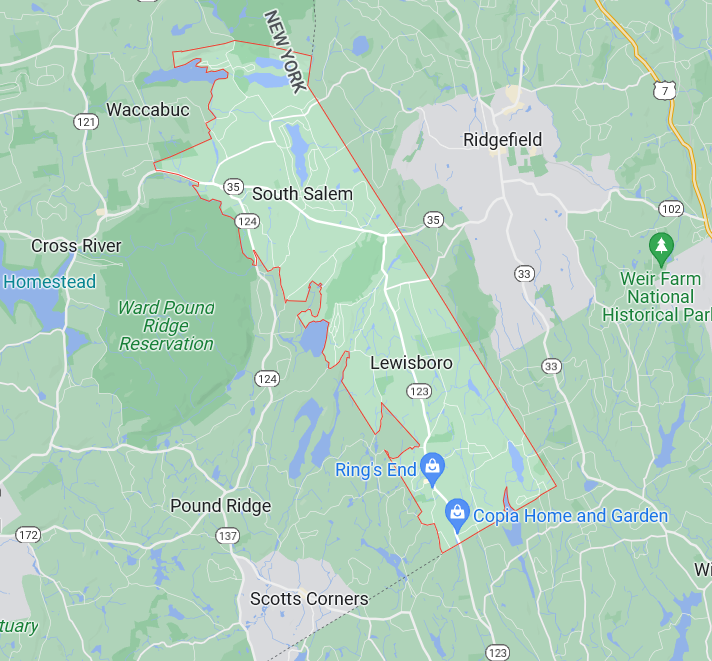

In [ ]:
model_comparison(Suburbs[10590])

No. 2, at 255.495%, is 10553. This zipcode is in Westchester County and includes much of easter Mount Vernon, NY.

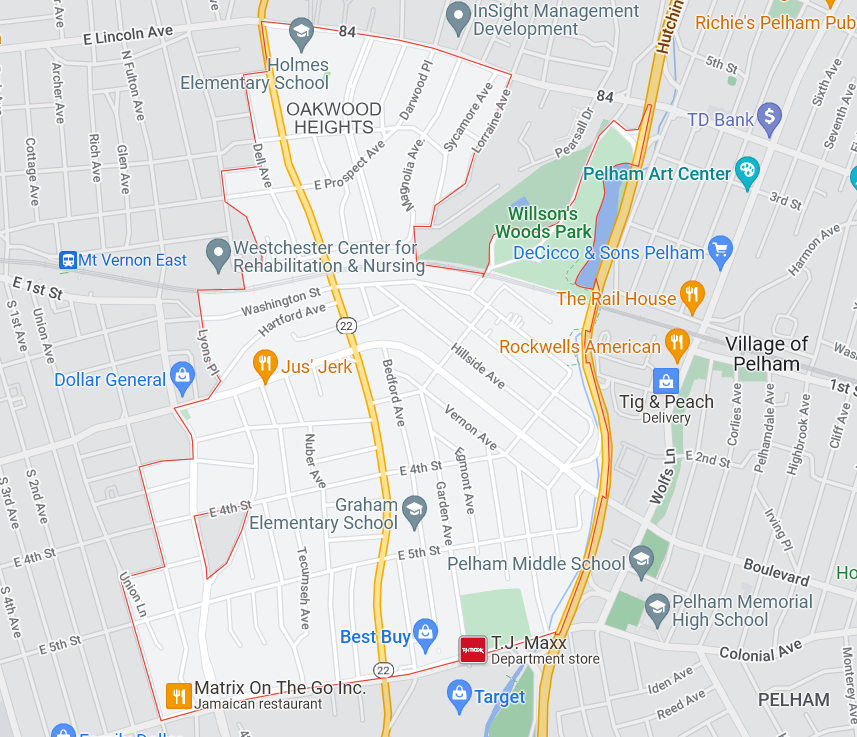

In [ ]:
model_comparison(Suburbs[10553])

No. 3, at 190.459% is 11804. This zipcode is in Nassau County and contains Old Bethpage, NY and parts of Bethpage, NY.

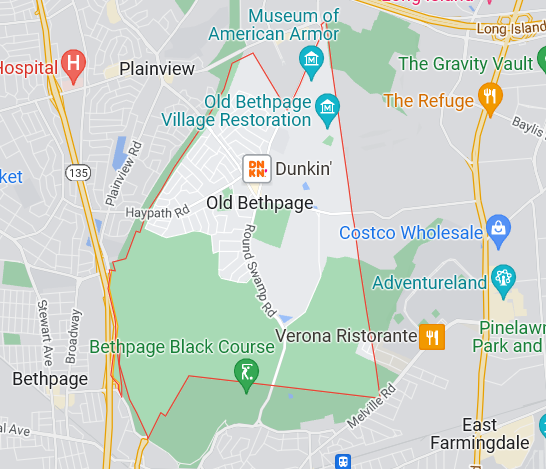

In [ ]:
model_comparison(Suburbs[11804])

No. 4, at 204.643%,  is 188.629. This zipcode is in Westchester County and includes parts of Katonah, NY, Goldens Bridge, NY, and Whitehall Corners, NY.

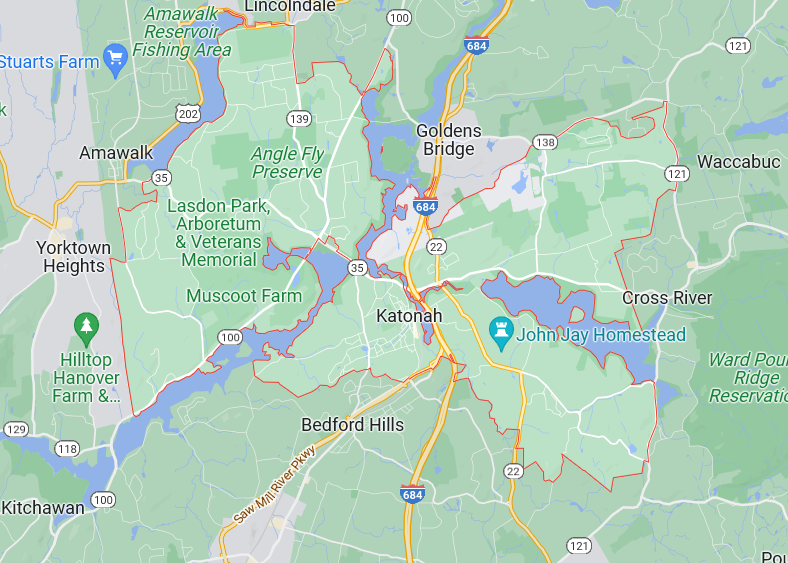

In [ ]:
model_comparison(Suburbs[10536])




No. 5, at 180.919%, is 10504. This zipcode is in Nassau County and contains parts of Armonk, NY, Chappaqua, NY, and Valhalla, NY.

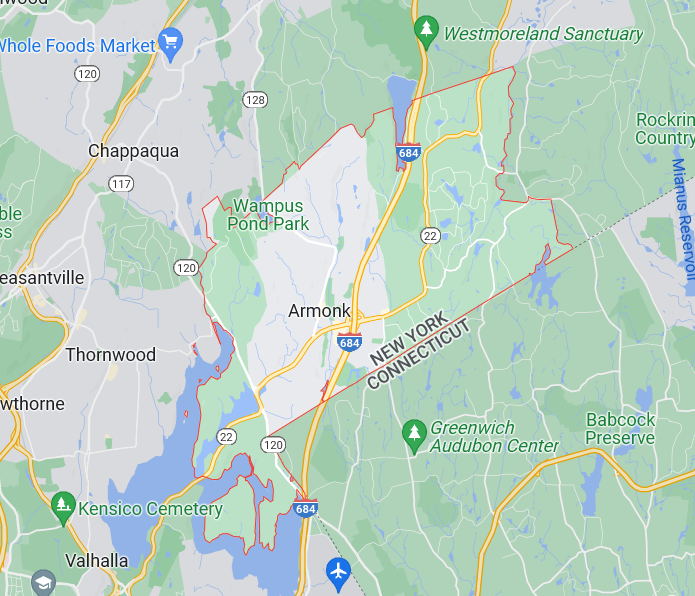

In [ ]:
model_comparison(Suburbs[10504])

# CONCLUSION

According to the model, **the top 5 zip codes with the highest ROI% from May 2018 to March 2023 were 10590, 10553, 11804,  10536, and 10504**. For each zip code, the predicted value far outstripped both the actual value and the baseline value for the time period. The confidence intervals for each zip code prediction is also very large. In 4 of the zip codes, the confidence intervals veer into negative $ amounts. Overall, the wide discrepancy in the actual ROI and the predicted ROI  and the wide confidence intervals may raise doubts about the efficacy of the model and its predictions. 

However, there may be meaningful reasons for the difference in predicted and actual ROI and the wide confidence intervals. 
The wide confidence intervals are a product of either a small sample or a large degree of variation in the data. I cannot say whether the sample was big enough but the graphs of the prices suggest that the data has a high degree of variation. For each zip code in the dataset, there is a fall around the time of the Great Financial Crisis or GFC(circa 2008). The values start to rise again in 2011 and either stabilize or continue to increase. However, the larger trend, from 1996 to 2018, is a significant increase for most of the zip codes. To speculate a bit, the discrepancy evidenced in zip code value in the predicted data and the baseline and original data for the top 5 predicted values may simply be the model anticipating the prices to move at a similar rate to the rate that they were moving before the Great Financial Crisis or to a similar place to where they would have moved if there had been no GFC. If one were to draw a line from the pre-GFC peak to March 2023 for each of the top 5 predicted ROI zip codes then that line would approach the predicted value for March 2023.

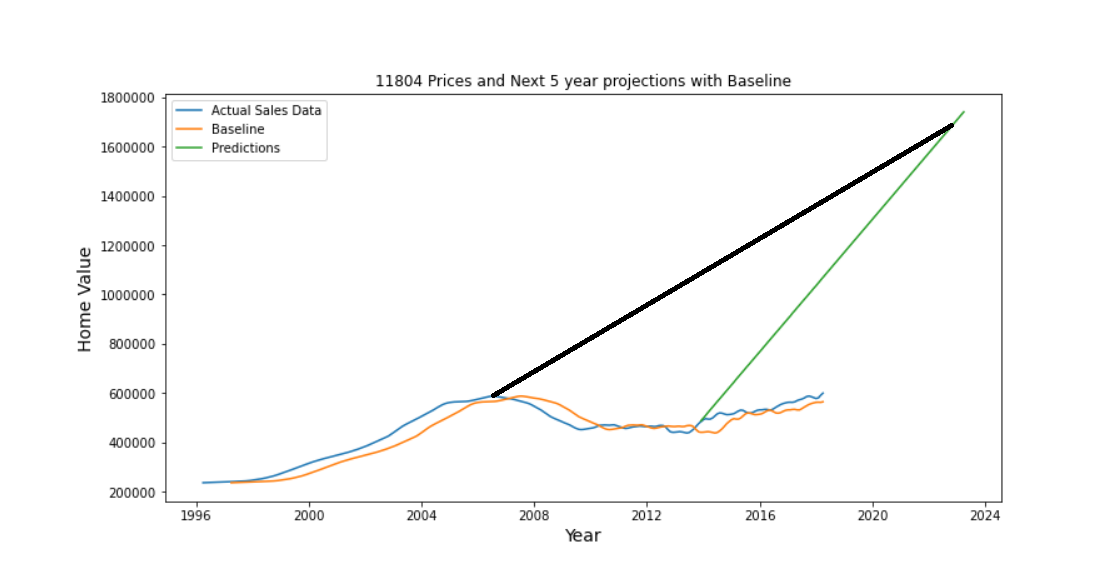

# NEXT STEPS
- An updated dataset that extends to 2022 would obviously be useful and would possibly generate more accurate predictions. It would also be interesting to see how a model would account for the COVID pandemic. The top 5 zipcodes would be especially interesting to look at since all of these zip codes except 10553 (which is solidly middle income) are wealthy suburbs with famously good schools where the average lot size is large and are full of residents who don't necessarily need to go into an office to work.
- More data on Fairfield County, CT would also be very useful to investors and to the model. Unfortunately, the Zillow dataset omitted many zip codes in Fairfield County, CT(parts of which are only a 40 minute train ride to Midtown, Manhattan and contain some of the wealthiest areas in the country) and also omitted data many zipcodes in the city itself. 
- Lastly, another ML model may yield more fruitful results. An XGBoost Regressor or a neural network model may yield better and more meaningful results.